In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

from agents import *
from environments import RaceTrack
from IPython.display import Image
from multiproc_utils import TrainPool

In [2]:
track = RaceTrack(RaceTrack.track_challenge)
track.set_eval()

#n = 5
alpha = 0.5
epsilon = 0.1
final_alpha = 0.0
final_epsilon = 0.0
selector = EpsilonGreedy(epsilon=epsilon)

alpha_schedule = SigmoidSchedule(
    ["learner", "alpha"],
    alpha,
    0.0,
)
epsilon_schedule = LinearSchedule(
    ["selector", "epsilon"],
    epsilon,
    final_epsilon,
)

In [3]:
learner = NStepTreeBackup(n=2, alpha=alpha)
tb2_agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        epsilon_schedule,
    ],
)

learner = NStepTreeBackup(n=3, alpha=alpha)
tb3_agent = Agent(
    num_states=track.num_states,
    num_actions=track.num_actions,
    selector=selector,
    learner=learner,
    schedules=[
        alpha_schedule,
        epsilon_schedule,
    ],
)

In [4]:
tb2_trainer = Trainer(agent=tb2_agent, env=track)
tb3_trainer = Trainer(agent=tb3_agent, env=track)

In [5]:
num_episodes = 10_000

pool = TrainPool([tb2_trainer, tb3_trainer], num_episodes)
updates = pool()

Training complete!
Training complete!
Receiving!
Receiving!


In [6]:
#Q, lens, rets = updates[0]
lens, rets = updates[0]
#tb2_agent.Q = Q
tb2_agent.ep_lengths = lens
tb2_agent.ep_returns = rets
#Q, lens, rets = updates[1]
lens, rets = updates[1]
#tb3_agent.Q = Q
tb3_agent.ep_lengths = lens
tb3_agent.ep_returns = rets

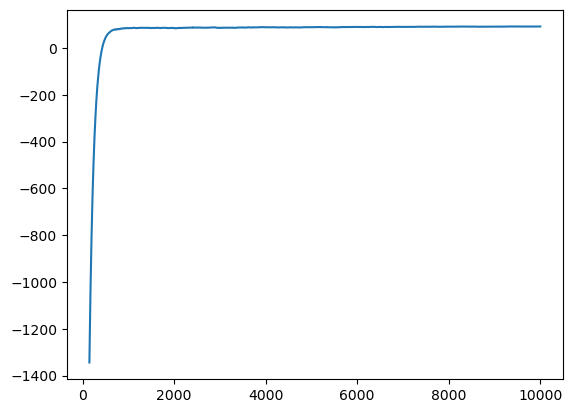

In [7]:
xs, ys = tb2_agent.smoothed_ep_returns(100)
plt.plot(xs[150:], ys[150:])
plt.show()

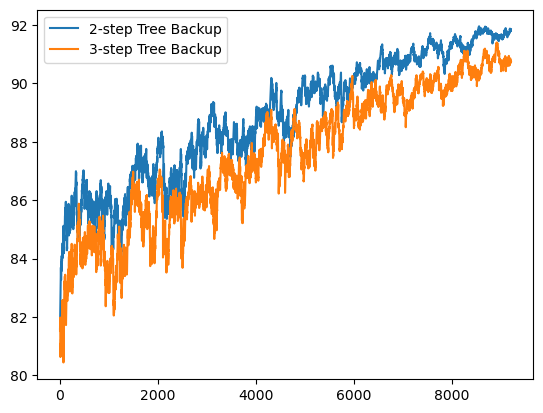

In [8]:
tb2_trailing_returns = np.zeros_like(tb2_agent.ep_returns)
tb2_trailing_returns[0] = tb2_agent.ep_returns[0]

step_size = 1 / 70
for i in range(1, len(tb2_agent.ep_returns)):
    tb2_trailing_returns[i] = step_size * tb2_agent.ep_returns[i] + (1 - step_size) * tb2_trailing_returns[i-1]

tb3_trailing_returns = np.zeros_like(tb3_agent.ep_returns)
tb3_trailing_returns[0] = tb3_agent.ep_returns[0]

for i in range(1, len(tb3_agent.ep_returns)):
    tb3_trailing_returns[i] = step_size * tb3_agent.ep_returns[i] + (1 - step_size) * tb3_trailing_returns[i-1]

start_from = 800
plt.plot(tb2_trailing_returns[start_from:], label=f"2-step Tree Backup")
plt.plot(tb3_trailing_returns[start_from:], label=f"3-step Tree Backup")
plt.legend()
plt.show()